## Define a Model 

We can use carrot.cdm to create destination tables and fields for our synthetic data model

In [1]:
from carrot.cdm.objects.common import DestinationTable, DestinationField

class Demographics(DestinationTable):
    name = 'Demo'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.Age = DestinationField(dtype="Integer", required=False)
        self.Sex = DestinationField(dtype="Text50", required=False )
        super().__init__(self.name,type(self).__name__)

class Symptoms(DestinationTable):
    name = 'Symptoms'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.date_occurrence = DestinationField(dtype="Timestamp", required=False)                                                                                     
        self.Headache = DestinationField(dtype="Text50", required=False )
        self.Fatigue = DestinationField(dtype="Text50", required=False )
        self.Dizzy = DestinationField(dtype="Text50", required=False )
        self.Cough = DestinationField(dtype="Text50", required=False )
        self.Fever = DestinationField(dtype="Text50", required=False )
        self.Muscle_Pain = DestinationField(dtype="Text50", required=False )
        super().__init__(self.name,type(self).__name__)
        
class GP_Records(DestinationTable):
    name = 'GP_Records'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.date_of_visit = DestinationField(dtype="Timestamp", required=False)                                                                                     
        self.comorbidity = DestinationField(dtype="Text50", required=False )
        self.comorbidity_value = DestinationField(dtype="Float", required=False )
        super().__init__(self.name,type(self).__name__)
        
class Hospital_Visit(DestinationTable):
    name = 'Hospital_Visit'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.admission_date = DestinationField(dtype="Timestamp", required=False)   
        self.reason = DestinationField(dtype="Text50", required=False )
        super().__init__(self.name,type(self).__name__)
        
class Blood_Test(DestinationTable):
    name = 'Blood_Test'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.date_taken = DestinationField(dtype="Timestamp", required=False)   
        self.location = DestinationField(dtype="Text50", required=False )
        self.quantity = DestinationField(dtype="Float", required=False )
        super().__init__(self.name,type(self).__name__)
        
class Vaccinations(DestinationTable):
    name = 'Vaccinations'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.date_of_vaccination = DestinationField(dtype="Timestamp", required=False)                                                                                     
        self.type = DestinationField(dtype="Text50", required=False)
        self.stage = DestinationField(dtype="Integer", required=False)
        super().__init__(self.name,type(self).__name__) 
        
        
class Serology(DestinationTable):
    name = 'Serology'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.Date = DestinationField(dtype="Timestamp", required=True)
        self.IgG = DestinationField(dtype="Float", required=False )
        super().__init__(self.name,type(self).__name__)


Then build a total model(dataset) based upon these tables, creating this with 50k people

In [2]:
import pandas as pd
import numpy as np
import datetime
import time
import io
import carrot
from carrot.cdm import CommonDataModel
from carrot.cdm import define_table

def create_gaus_time_series(mu,sigma,n):
    mu = time.mktime(mu.timetuple())
    sigma = (datetime.timedelta(**sigma)).total_seconds()
    return pd.Series([datetime.date.fromtimestamp(x) for x in np.random.normal(mu,sigma,n)])

class ExampleCovid19DataSet(CommonDataModel):
    def __init__(self):
        """                                                                                                                                                    
        initialise the inputs and setup indexing                                                                                                               
        """  
        #50k people
        n = 50000
        
        
        outputs = carrot.tools.create_sql_store(connection_string="postgresql://localhost:5432/ExampleCOVID19DataSet",
                                          drop_existing=True)
        super().__init__(format_level=0,outputs=outputs)

        #create people indexes that we can use in the different tables
        self.people = pd.DataFrame([f'pk{i}' for i in range(1,n+1)],columns=['pks'])
        
        #set the processing order, e.g we want to build demographics table first
        #so that the values recorded in other tables can be demographically dependent 
        self.set_execution_order([
            'Demographics', 
            'GP_Records', 
            'Vaccinations',
            'Serology',
            'Symptoms',
            'Hospital_Visit',
            'Blood_Test'
        ])
        self.process()
      
    @define_table(Demographics)
    def demo(self):  
        """
        Straight foreward demographics
        """
        self.ID.series = self.cdm.people['pks']
        self.n = len(self.ID.series)
        self.Age.series = pd.Series(np.random.normal(60,20,self.n)).astype(int)
        self.Age.series = self.Age.series.mask(self.Age.series < 0 , None)
        self.Sex.series = pd.Series(np.random.choice(['Male','Female',None],size=self.n,p=[0.55,0.445,0.005]))
        
        
    @define_table(Symptoms)
    def symptoms(self):
        npeople = self.cdm.demo.n
        nsymptoms = npeople*5

        ID = self.cdm.demo.ID.series
        
        self.ID.series = ID.sample(int(npeople*0.8))\
            .sample(nsymptoms,replace=True)\
            .sort_values().reset_index(drop=True)  

        self.date_occurrence.series = create_gaus_time_series(mu=datetime.datetime(2021,1,1),
                                                              sigma={'days':365},
                                                              n=nsymptoms)
        
        self.date_occurrence.series.loc[self.date_occurrence.series.sample(frac=0.005).index] = np.nan
        
        syms_probs = {'Headache':0.8,'Fatigue':0.7,'Dizzy':0.4,'Cough':0.7,'Fever':0.2,'Muscle_Pain':0.1}
        for key,p in syms_probs.items():
            series = pd.Series(np.random.choice(['Yes','No'],size=nsymptoms,p=[p,1-p]))
            setattr(getattr(self,key),'series',series)
            
    @define_table(Serology)
    def serology(self):
        
        def calc_IgG(age,sex,nrisks):
            scale = 50*(1 - age/200)*(1.1 if sex=='Female' else 1.0)*(1/nrisks)
            return np.random.exponential(scale=scale)
        
        df_gp = self.cdm.gp.get_df()
        df_nrisks = df_gp['comorbidity'].groupby(df_gp.index)\
                    .count()
        df_nrisks.name ='nrisks'

        df = self.cdm.demo.get_df().join(df_nrisks).reset_index()
        df['nrisks'] = df['nrisks'].fillna(1)

        df = df[df['Age']>18].sample(frac=0.3)
        nstudies = len(df)

        df = df.sample(frac=1.4,replace=True).reset_index()

        df['IgG'] = df.apply(lambda x : calc_IgG(x.Age,x.Sex,x.nrisks),axis=1)
        df.sort_values('ID',inplace=True)
        
        self.IgG.series = df['IgG']
        self.ID.series = df['ID']
        self.Date.series = create_gaus_time_series(mu=datetime.datetime(2021,5,1),
                                                              sigma={'days':365},
                                                              n=len(df))
           
    @define_table(GP_Records)
    def gp(self):
    
        def calc_comoribidites(age):
            if pd.isna(age):
                return []   
            comorbidities = {
                'Mental Health':0.3*(1 + age/90) ,
                'Diabetes Type-II':0.15*(1 + age/70) ,
                'Heart Condition':0.1*(1 + age/50) ,
                'High Blood Pressure':0.07*(1 + age/60),
                'BMI': 1
            }
            return [x for x,p in comorbidities.items() if np.all(np.random.uniform() < p) ]
        
        #90% of people have a GP visit record
        df = self.cdm.demo.get_df().sample(frac=0.9).reset_index()
        
        df['comorbidity'] = df.apply(lambda x: calc_comoribidites(x.Age),axis=1)
        df['date_of_observation'] = create_gaus_time_series(mu=datetime.datetime(2010,5,1),
                                                              sigma={'days':700},
                                                              n=len(df))
        
        df = df.explode('comorbidity').set_index('ID').sort_index()
    
        self.ID.series = df.index.to_series()
        self.comorbidity.series = df['comorbidity']
        self.comorbidity_value.series = df['comorbidity'].apply(lambda x: np.random.exponential(scale=20)
                                                                if x == 'BMI' else 1)
        self.date_of_visit.series = df['date_of_observation']
        
    @define_table(Hospital_Visit) 
    def hospital(self):
        
        n = len(self.cdm.demo.ID.series)
        
        #5% of people have had a hospital visit
        #some of those have multiple visists
        self.ID.series = self.cdm.demo.ID.series.sample(n)\
                        .sample(int(n*1.2),replace=True)\
                        .sort_values().reset_index(drop=True)  
        
        n = len(self.ID.series)
        self.admission_date.series = create_gaus_time_series(mu=datetime.datetime(2020,5,1),
                                                              sigma={'days':300},
                                                              n=n)
    
        reasons = {
            'Kidney Operation':0.1,
            'Appendix Operation':0.1,
            'Heart Attack':0.2,
            'COVID-19':0.15,
            'Pneumonia':0.15,
            'Cancer':0.3
        }

        self.reason.series = pd.Series(np.random.choice(list(reasons.keys()),size=n,p=list(reasons.values())))

    @define_table(Blood_Test)
    def bloods(self):
        #half of the people with hospital visits have blood taken
        df_hospital = self.cdm.hospital.get_df().sample(frac=0.5).reset_index()
        
        self.ID.series = df_hospital['ID']
        self.date_taken.series = pd.to_datetime(df_hospital['admission_date']) \
                               + datetime.timedelta(days=np.random.uniform(0,5))
        
        n = len(df_hospital)
        self.location.series = pd.Series(np.random.choice(['Right Arm','Left Arm','Small Intestine','Abdominal Wall'],
                                                   size=n,
                                                   p=[0.3,0.3,0.2,0.2]))
        self.quantity.series = pd.Series((np.random.exponential(scale=1.5) for _ in range(0,n)))
        
    @define_table(Vaccinations)
    def first_covid_vaccination(self):
        
        def calc_date_of_vacc(age):
            if pd.isna(age):
                return np.nan
            start_date = datetime.datetime(2021,1,1)
            tdelta = datetime.timedelta(days=(300-age*2)+np.random.uniform(0,50))
            
            return start_date + tdelta
            
        #95% of people have had a vaccination
        df = self.cdm.demo.get_df().sample(frac=0.9).reset_index()
        
        self.ID.series = df['ID']
        self.date_of_vaccination.series =  df.apply(lambda x : calc_date_of_vacc(x.Age),axis=1)
        n = len(self.ID.series)
        self.type.series = pd.Series(np.random.choice(['Moderna','AstraZenica','Pfizer'],size=n,p=[0.34,0.33,0.33]))
        self.stage.series = pd.Series((0 for _ in range(0,n)))
       
    @define_table(Vaccinations)
    def second_covid_vaccination(self):
        
        def calc_date_of_vacc(age):
            if pd.isna(age):
                return np.nan
            start_date = datetime.datetime(2021,1,1)
            tdelta = datetime.timedelta(days=(300-age*2)+np.random.uniform(0,50))
            
            return start_date + tdelta
            
        #80% of people who had 1st had 2nd
        df = self.cdm.first_covid_vaccination.get_df().sample(frac=0.8).reset_index()
        
        self.ID.series = df['ID']
        self.date_of_vaccination.series =  pd.to_datetime(df['date_of_vaccination']) \
                                           + datetime.timedelta(days=(50+np.random.uniform(0,50)))
        n = len(self.ID.series)
        self.type.series = pd.Series(np.random.choice(['Moderna','AstraZenica','Pfizer'],size=n,p=[0.34,0.33,0.33]))
        self.stage.series = pd.Series((1 for _ in range(0,n)))
        
        
     

## Create a Model
Create and run the model, for a dataset so large and complex, this can take some time

In [3]:
model = ExampleCovid19DataSet()
model

2022-06-17 15:03:24 - SqlDataCollection - INFO - DataCollection Object Created
2022-06-17 15:03:25 - SqlDataCollection - INFO - Engine(postgresql://localhost:5432/ExampleCOVID19DataSet)
2022-06-17 15:03:25 - ExampleCovid19DataSet - INFO - CommonDataModel (5.3.1) created with co-connect-tools version 0.0.0
2022-06-17 15:03:25 - ExampleCovid19DataSet - INFO - Turning on automatic cdm column filling
2022-06-17 15:03:25 - ExampleCovid19DataSet - INFO - Added bloods of type Blood_Test
2022-06-17 15:03:25 - ExampleCovid19DataSet - INFO - Added demo of type Demographics
2022-06-17 15:03:25 - ExampleCovid19DataSet - INFO - Added first_covid_vaccination of type Vaccinations
2022-06-17 15:03:25 - ExampleCovid19DataSet - INFO - Added gp of type GP_Records
2022-06-17 15:03:25 - ExampleCovid19DataSet - INFO - Added hospital of type Hospital_Visit
2022-06-17 15:03:25 - ExampleCovid19DataSet - INFO - Added second_covid_vaccination of type Vaccinations
2022-06-17 15:03:25 - ExampleCovid19DataSet - INF

2022-06-17 15:03:39 - SqlDataCollection - INFO - updating Vaccinations in Engine(postgresql://localhost:5432/ExampleCOVID19DataSet)
2022-06-17 15:03:48 - SqlDataCollection - INFO - finished save to psql
2022-06-17 15:03:48 - ExampleCovid19DataSet - INFO - finalised Vaccinations on iteration 0 producing 81000 rows from 2 tables
2022-06-17 15:03:48 - ExampleCovid19DataSet - INFO - for Serology: found 1 object
2022-06-17 15:03:48 - ExampleCovid19DataSet - INFO - working on Serology
2022-06-17 15:03:48 - ExampleCovid19DataSet - INFO - starting on serology
2022-06-17 15:03:49 - Serology - INFO - Not formatting data columns
2022-06-17 15:03:49 - Serology - INFO - created df (0x10bd35be0)[serology]
2022-06-17 15:03:49 - ExampleCovid19DataSet - INFO - finished serology (0x10bd35be0) ... 1/1 completed, 20591 rows
2022-06-17 15:03:49 - ExampleCovid19DataSet - INFO - saving dataframe (0x10b6b6cd0) to <carrot.io.plugins.sql.SqlDataCollection object at 0x107742100>
2022-06-17 15:03:49 - SqlDataColl

## Viewing the Model

Print to see what output data tables the model contains

In [4]:
model.keys()

dict_keys(['Demographics', 'GP_Records', 'Vaccinations', 'Serology', 'Symptoms', 'Hospital_Visit', 'Blood_Test'])

retrieve the dataframes from the model

In [5]:
model['Demographics']

,Age,Sex
ID,,
pk1,62.0,Male
pk2,56.0,Female
pk3,37.0,Male
pk4,57.0,Female
pk5,55.0,Male
...,...,...
pk45025,124.0,Male
pk47056,29.0,None
pk49115,61.0,None


In [6]:
model['GP_Records']

,date_of_visit,comorbidity,comorbidity_value
ID,,,
pk1,2007-10-21,Diabetes Type-II,1.000000
pk1,2007-10-21,Heart Condition,1.000000
pk1,2007-10-21,BMI,48.725715
pk10,2009-01-03,Mental Health,1.000000
pk10,2009-01-03,BMI,23.007635
...,...,...,...
pk9994,2009-08-09,BMI,58.675133
pk9995,2012-09-06,BMI,46.737545
pk9996,2010-04-13,BMI,1.468812


In [7]:
model['Vaccinations']

,date_of_vaccination,type,stage
ID,,,
pk32019,2021-07-18 21:19:36.566949,Moderna,0
pk32821,2021-09-07 23:08:09.986958,AstraZenica,0
pk40642,2021-08-17 22:21:06.467002,Pfizer,0
pk30449,2021-08-31 08:30:15.911471,AstraZenica,0
pk34545,2021-06-26 14:03:28.892069,Moderna,0
...,...,...,...
pk31142,2021-07-08 00:53:53.763942,Pfizer,1
pk22055,2021-08-17 01:57:34.407304,AstraZenica,1
pk38363,2021-11-21 07:48:46.199824,AstraZenica,1


In [8]:
model['Serology']

,Date,IgG
ID,,
pk10001,2021-03-17,13.701676
pk10001,2021-07-29,1.077413
pk10005,2020-06-06,39.366639
pk10005,2020-03-02,56.358177
pk10009,2021-05-03,55.585361
...,...,...
pk997,2020-12-14,1.720815
pk9978,2020-11-10,52.239568
pk9982,2023-05-12,5.753619


In [9]:
model['Symptoms']

,date_occurrence,Headache,Fatigue,Dizzy,Cough,Fever,Muscle_Pain
ID,,,,,,,
pk1,2021-01-24,Yes,Yes,No,Yes,No,Yes
pk1,2019-05-30,Yes,Yes,No,No,Yes,No
pk1,2021-05-16,Yes,No,No,No,Yes,No
pk1,2022-06-11,Yes,Yes,Yes,Yes,No,No
pk1,2020-06-18,Yes,Yes,Yes,Yes,Yes,Yes
...,...,...,...,...,...,...,...
pk9992,2021-11-22,No,No,No,No,No,Yes
pk9992,2019-11-07,Yes,Yes,No,Yes,Yes,Yes
pk9992,2018-09-01,Yes,Yes,No,No,Yes,Yes


In [10]:
model['Blood_Test']

,date_taken,location,quantity
ID,,,
pk31048,2019-05-24 13:00:52.371957,Right Arm,0.858088
pk42771,2020-12-04 13:00:52.371957,Right Arm,0.362495
pk9294,2019-08-18 13:00:52.371957,Left Arm,0.674107
pk34653,2020-06-11 13:00:52.371957,Small Intestine,0.994321
pk34474,2020-06-13 13:00:52.371957,Left Arm,0.520345
...,...,...,...
pk2856,2021-03-03 13:00:52.371957,Left Arm,0.358316
pk46915,2020-01-19 13:00:52.371957,Left Arm,0.387136
pk32960,2019-10-12 13:00:52.371957,Left Arm,0.563794


In [11]:
model['Hospital_Visit']

,admission_date,reason
ID,,
pk1,2020-03-20,Cancer
pk1000,2019-02-14,Pneumonia
pk10001,2019-10-10,Appendix Operation
pk10001,2021-01-13,Cancer
pk10001,2018-11-30,COVID-19
...,...,...
pk9843,2018-10-04,COVID-19
pk9904,2018-05-15,Appendix Operation
pk9913,2022-06-14,Pneumonia


## Perform analysis

Firstly get the the GP records, and count the number of comorbidities a patient has, to create risk groups

In [12]:
df_gp = model['GP_Records']
df_nrisks = df_gp.groupby(df_gp.index)['comorbidity'].count() 
df_nrisks.name = 'nrisks'
df_nrisks.value_counts().to_frame().sort_index()

,nrisks
0,40
1,35767
2,6920
3,1927
4,313
5,33


build a dataframe for analysis by getting the serology data + demographics data + the number of risks

In [13]:
df = model['Serology'].join(model['Demographics']).join(df_nrisks).fillna(0)
df

,Date,IgG,Age,Sex,nrisks
ID,,,,,
pk10001,2021-03-17,13.701676,0.0,0,2.0
pk10001,2021-07-29,1.077413,0.0,0,2.0
pk10005,2020-06-06,39.366639,0.0,0,3.0
pk10005,2020-03-02,56.358177,0.0,0,3.0
pk10009,2021-05-03,55.585361,0.0,0,1.0
...,...,...,...,...,...
pk997,2020-12-14,1.720815,0.0,0,1.0
pk9978,2020-11-10,52.239568,0.0,0,1.0
pk9982,2023-05-12,5.753619,0.0,0,1.0


Produce some plots show how there is a difference in the IgG response for different age and risk groups

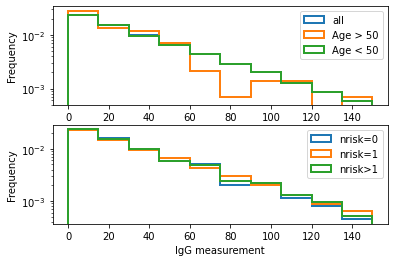

In [14]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(2)
ax = axs[0]

df['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),histtype='step',lw=2,density=True,label='all')
df[df['Age']>50]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='Age > 50')
df[df['Age']<50]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='Age < 50')
ax.set_yscale('log')
ax.set_xlabel('IgG measurement')
ax.legend()

ax = axs[1]
df[df['nrisks']<1]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='nrisk=0')
df[df['nrisks']==1]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='nrisk=1')
df[df['nrisks']>1]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='nrisk>1')

ax.set_yscale('log')
ax.set_xlabel('IgG measurement')
ax.legend()
plt.show();